In [ ]:
# import required packages
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN, LSTM, GRU
import matplotlib.pyplot as plt
import time
import math
import xgboost as xgb
from xgboost import plot_importance
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statistics import stdev
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot

In [ ]:
# Import data
pd.set_option('display.max_columns',100)
# data without sentiment
sp500df = pd.read_excel("./FINAL JOIN.xlsx",header=1)
# data with sentiment
# sp500df = pd.read_excel("./FINAL JOIN_with sentiment.xlsx",header=1)
sp500df.drop(columns=["VOLUME(US$BILLIONS)","TARGET RATE/RANGE(PERCENT)"],inplace=True)

# Technical Indicators

In finance, a moving average(MA) is a stock indicator that is commonly used in technical analysis. The reason for calculating the moving average of a stock is to help smooth out the price by creating a constantly updated average price.

In [ ]:
def technical_indicators(data):
    # get 8 and 21 days Exponential Moving Average
    tech_indicators = data.copy()
    tech_indicators['ema8'] = tech_indicators['Close'].ewm(span=8,adjust=False,min_periods=8).mean()
    tech_indicators['ema21'] = tech_indicators['Close'].ewm(span=21,adjust=False,min_periods=21).mean()
    
    # # Create MACD
    ema12 = tech_indicators['Close'].ewm(span=12,adjust=False,min_periods=12).mean()
    ema26 = tech_indicators['Close'].ewm(span=26,adjust=False,min_periods=26).mean()
    diff = ema12 - ema26
    tech_indicators['macd']=diff

    # # Create Bollinger Bands
    ma20sd  = tech_indicators['Close'].rolling(window=20).std()
    ma20 = tech_indicators['Close'].rolling(window=20).mean()
    tech_indicators['bl_upper'] = ma20 + (ma20sd*2)
    tech_indicators['bl_lower'] = ma20 - (ma20sd*2)

    tech_indicators.dropna(inplace=True)

    return tech_indicators

sp500df_cp = technical_indicators(sp500df)
sp500df_cp = sp500df_cp[sp500df_cp['Date']<'2020-07-01'].copy()
sp500df_cp = sp500df_cp[sp500df_cp['Date']>'2010-12-31'].copy()

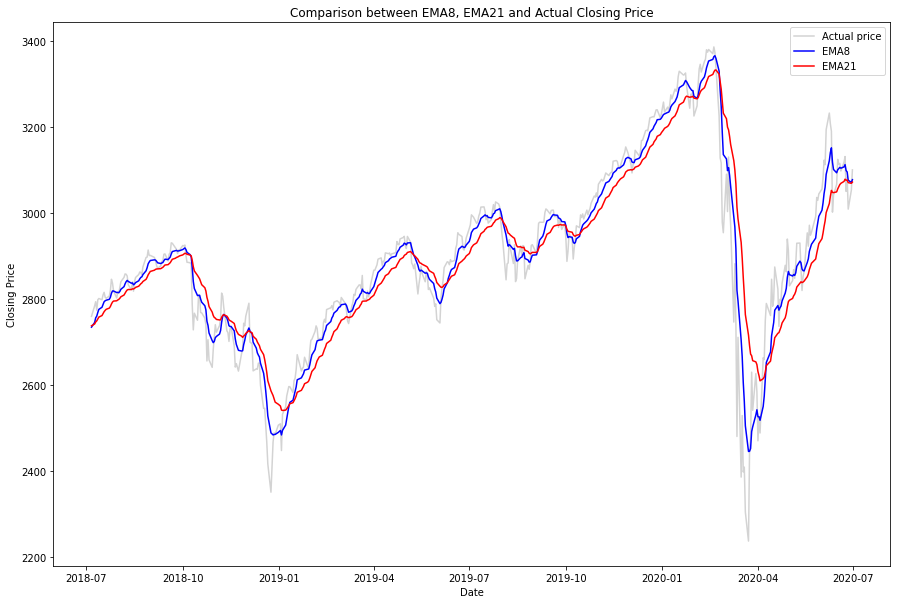

In [ ]:
real_data = sp500df_cp[['Close']].copy()
read_data_500 = real_data.iloc[-500:,]
ema8 = sp500df_cp[['ema8']].copy()
ema8_500 = ema8.iloc[-500:,]
ema21 = sp500df_cp[['ema21']].copy()
ema21_500 = ema21.iloc[-500:,]
#Plotting original stock price
plt.figure(figsize=(15,10))
plt.title('Comparison between EMA8, EMA21 and Actual Closing Price')
plt.plot(sp500df_cp[['Date']].iloc[-500:,], read_data_500, label='Actual price',color='lightgrey')
plt.plot(sp500df_cp[['Date']].iloc[-500:,], ema8_500, label='EMA8',color='blue')
plt.plot(sp500df_cp[['Date']].iloc[-500:,],ema21_500,label='EMA21',color='red')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

# Preprocessing discrete

To predict the trend for the following day.

In [ ]:
data_01 = sp500df_cp.copy()
# get the discrete close column which indicates the direction of SPX
# if the price next day is higher, then the direction will be considered as rise, vice versa.
X = data_01['Close01'] = 0
for row in range(len(data_01)-1):
  if data_01['Close'].iloc[row+1] > data_01['Close'].iloc[row]:
    data_01['Close01'].iloc[row+1] = 1
data_01 = data_01.drop(columns=["Low","High","Close","Date"], axis=1)
data_01 = data_01[1:]  # remove the first row


# select independent variables and dependent variables, and split train/test.
y = data_01['Close01']
x = data_01.drop(columns=['Close01'],axis=1,inplace=False)
# sum(y)/len(y)  # sample balance
scaler = preprocessing.MinMaxScaler().fit(x) 
scaled_x = scaler.transform(x)
x_train, x_test, y_train, y_test = train_test_split(scaled_x, y, test_size=0.3, random_state=2020)


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


# Logistic Regreession

In [ ]:
# build the model with default parameters
lr = LogisticRegression(random_state=420)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

# the accuracy and confusion matrix for evaluation
score = accuracy_score(y_pred,y_test)
lr_cm = confusion_matrix(y_test, y_pred)

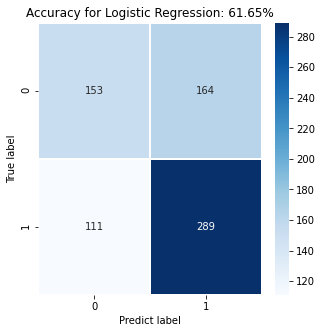

In [ ]:
# create confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(lr_cm, annot=True, linewidth=0.5, fmt='.0f', cmap='Blues')
plt.title(f'Accuracy for Logistic Regression: {score*100:.2f}%')
plt.xlabel('Predict label')
plt.ylabel('True label')
plt.show()

In [ ]:
# optimization - find the optimal C for logistic regression
score1_, score2_ = [], []
C = np.arange(0.001,6.001,0.03)

for i in C:
  lr = LogisticRegression(penalty='l2',solver='sag',random_state=420,C=i,max_iter=300)
  lr.fit(x_train, y_train)
  score1_.append(lr.score(x_train,y_train))
  score2_.append(lr.score(x_test,y_test))

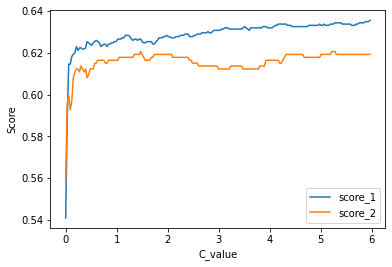

In [ ]:
plt.plot(C,score1_,label="score_1")
plt.plot(C,score2_,label="score_2")
plt.xlabel('C_value')
plt.ylabel('Score')
plt.legend()
plt.show()

optimal C is: 5.971, with highest accuracy: 61.92%


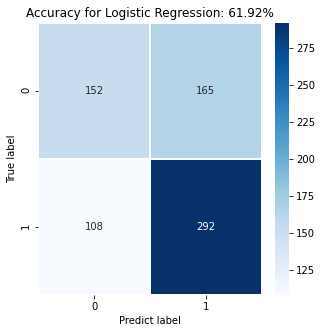

In [ ]:
# optimized Logistic Regression with optimal C
scoremax = max(score1_)
opt_C = C[score1_.index(max(score1_))]

lr_opt = LogisticRegression(penalty='l2',solver='sag',random_state=420,C=opt_C,max_iter=300)
lr_opt.fit(x_train, y_train)
y_pred = lr_opt.predict(x_test)
score = lr.score(x_test,y_test)

# plot confusion matrix
lr_cm = confusion_matrix(y_test, y_pred)
print(f"optimal C is: {opt_C}, with highest accuracy: {score*100:.2f}%")
import seaborn as sns
plt.figure(figsize=(5,5))
sns.heatmap(lr_cm, annot=True, linewidth=0.5, fmt='.0f', cmap='Blues')
plt.title(f'Accuracy for Logistic Regression: {score*100:.2f}%')
plt.xlabel('Predict label')
plt.ylabel('True label')
plt.show()

# Decision Tree (Classifier)

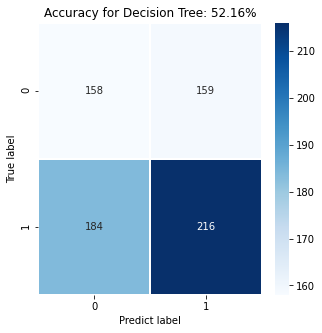

In [ ]:
# 1. build decision tree to the maximum
dt_classifier = tree.DecisionTreeClassifier()
dt_classifier = dt_classifier.fit(x_train, y_train)

# plot confusion matrix to display the accuracy
y_pred = dt_classifier.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
#print(cm)

accuracy = accuracy_score(y_test, y_pred) * 100
#print(f"Accuracy: {accuracy:.2f}%")

# plot the confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, linewidth=0.5, fmt='.0f', cmap='Blues')
plt.title(f'Accuracy for Decision Tree: {accuracy:.2f}%')
plt.xlabel('Predict label')
plt.ylabel('True label')
plt.show()

# plot the tree
#tree.plot_tree(dt_classifier)


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

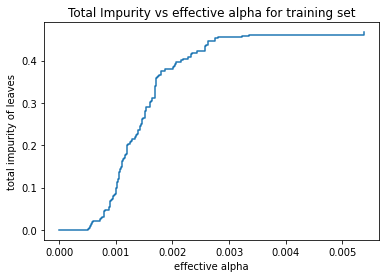

In [ ]:
# return the effective alphas and the corresponding total leaf impurities at each step of the pruning process
clf=dt_classifier
path = clf.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

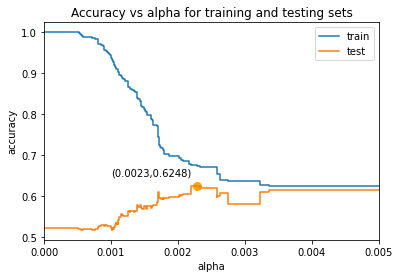

Optimal ccp_alpha for decision tree is: 0.0023, with highest accuracy: 62.48%


In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)
#print(f"Number of nodes in the last tree is: {clfs[-1].tree_.node_count} with ccp_alpha: {ccp_alphas[-1]}")

train_scores = [clf.score(x_train, y_train) for clf in clfs]
test_scores = [clf.score(x_test, y_test) for clf in clfs]

# find the optimal ccp_alpha value for highest accuracy
max_index = test_scores.index(max(test_scores))
optimal_ccp_alpha = ccp_alphas[max_index]

# plot the accuracy for each ccp_alpha value
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
plt.plot(optimal_ccp_alpha,max(test_scores),marker="o",markersize=8, color="orange")
ax.plot(ccp_alphas, train_scores, label="train", drawstyle="steps-post")
point = (f"({optimal_ccp_alpha:.4f},{max(test_scores):.4f})")
ax.annotate(point, xytext = (0.001,0.65), xy=(optimal_ccp_alpha,max(test_scores)))
ax.plot(ccp_alphas, test_scores, label="test", drawstyle="steps-post")
ax.legend()
plt.xlim(0,0.005)
plt.show()


print(f"Optimal ccp_alpha for decision tree is: {optimal_ccp_alpha:.4f}, with highest accuracy: {max(test_scores)*100:.2f}%")

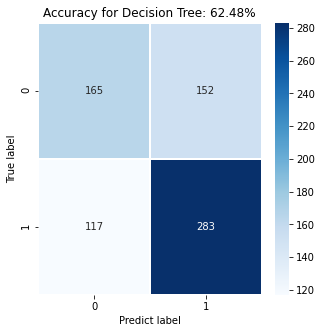

In [ ]:
# optimized decision tree with optimal cp value
clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=0.0023)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
cm = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, linewidth=0.5, fmt='.0f', cmap='Blues')
plt.title(f'Accuracy for Decision Tree: {max(test_scores)*100:.2f}%')
plt.xlabel('Predict label')
plt.ylabel('True label')
plt.show()

# plot the tree
#tree.plot_tree(dt_classifier)

# Preprocessing continous

To predict the exact stock price.

In [ ]:
# select independent variables and dependent variable
Y = sp500df_cp[['Close']]
X = sp500df_cp.drop(columns=["High","Close","Low",'Date'])

# normalization
scalerX = preprocessing.MinMaxScaler().fit(X)
scaled_X = scalerX.transform(X)
scalerY = preprocessing.MinMaxScaler().fit(Y)
scaled_Y = scalerY.transform(Y)

# train and test split
cutNo = int(round((1-0.3)*len(scaled_X)))
scaled_X_train, scaled_X_test = np.array(scaled_X[:cutNo]), np.array(scaled_X[cutNo:])
scaled_Y_train, scaled_Y_test = np.array(scaled_Y[:cutNo]), np.array(scaled_Y[cutNo:])

# Decision Tree (Regressor)

In [ ]:
# build the model with default parameters
regr_1 = DecisionTreeRegressor(random_state = 2020)
regr_1.fit(scaled_X_train, scaled_Y_train)
path = regr_1.cost_complexity_pruning_path(scaled_X_train, scaled_Y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# prediction and evaluation for the performance(accuracy)
y_pred = regr_1.predict(scaled_X_test).reshape([-1,1])
y_pred_real = scalerY.inverse_transform(y_pred)
y_test_real = scalerY.inverse_transform(scaled_Y_test)

MSE = mean_squared_error(y_test_real, y_pred_real)
RMSE = math.sqrt(MSE)
y_test_mean = np.mean(y_test_real)
Accuracy = (1-RMSE/y_test_mean)
print(f"The initial Accuracy for decision tree is: {Accuracy*100:.2f}%")

# pruning the tree
## getting all the different clf based on different ccp_alpha
test_mses = []
for ccp_alpha in ccp_alphas:
    regr = tree.DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)   
    regr.fit(scaled_X_train, scaled_Y_train)
    y_pred_test2 = regr.predict(scaled_X_test)
    testmse = mean_squared_error(scaled_Y_test, y_pred_test2)
    test_mses.append(testmse)

# find the best tree
print('lowest validation MSE after pruning the tree: {:.4f}'.format(min(test_mses)))
bestreg_index = test_mses.index(min(test_mses))
best_reg = tree.DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alphas[bestreg_index])
print(f"The optimal cp value for decision tree is: {ccp_alphas[bestreg_index]}")
best_reg.fit(scaled_X_train, scaled_Y_train)
y_pred = best_reg.predict(scaled_X_test).reshape([-1,1])
y_pred_real = scalerY.inverse_transform(y_pred)
y_test_real = scalerY.inverse_transform(scaled_Y_test)

print('DT Mean squared error for testset: %.4f'
      % mean_squared_error(y_pred_real, y_test_real))

MSE = mean_squared_error(y_test_real, y_pred_real)
RMSE = math.sqrt(MSE)
y_test_mean = np.mean(y_test_real)
Accuracy = (1-RMSE/y_test_mean)

print(f"MSE for best tree: {MSE:.6f}")
print(f"RMSE for best tree: {RMSE:.6f}")
print(f'Best Accuracy for decision tree is: {Accuracy*100:.2f}%')

The initial Accuracy for decision tree is: 84.92%
lowest validation MSE after pruning the tree: 0.0327
The optimal cp value for decision tree is: 2.3014631604812175e-07
DT Mean squared error for testset: 171074.1628
MSE for best tree: 171074.162774
RMSE for best tree: 413.611125
Best Accuracy for decision tree is: 85.36%


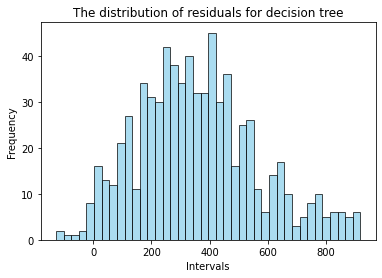

In [ ]:
# plot residuals distribution for decision tree
residuals = y_test_real - y_pred_real
plt.hist(residuals, bins=40, facecolor="skyblue", edgecolor="black", alpha=0.7)
plt.xlabel("Intervals")
plt.ylabel("Frequency")
plt.title("The distribution of residuals for decision tree")
plt.show()

# XGboost

[17:15:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 422.720367
Accuracy: 85.04%


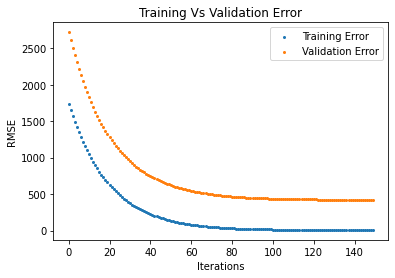

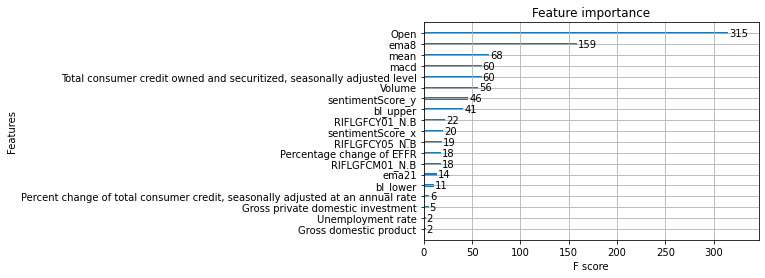

In [ ]:
# train and test split
def xgb_prepoccessing(X,Y,splitratio):
    train_n = int(X.shape[0] * splitratio)
    X_train, X_test = X.iloc[:train_n,:], X.iloc[train_n:,:]
    y_train, y_test = Y.iloc[:train_n], Y.iloc[train_n:]
    return X_train, X_test, y_train, y_test

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = xgb_prepoccessing(X,Y,0.7)
xgb_ephos = 150

# build the model
xgbreg = xgb.XGBRegressor(gamma=0.0,n_estimators=xgb_ephos,colsample_bytree=1,learning_rate=0.05)
# xgbModel = xgbreg.fit(scaled_X_train,scaled_Y_train, eval_set = [(scaled_X_train, scaled_Y_train), (scaled_X_test, scaled_Y_test)], verbose=False)
xgbModel = xgbreg.fit(X_train_xgb,y_train_xgb, eval_set = [(X_train_xgb, y_train_xgb), (X_test_xgb, y_test_xgb)], verbose=False)
xgb_result = xgbreg.evals_result()

# evaluation (MSE and accuracy) for XGBoost
RMSE = min(xgb_result['validation_1']['rmse'])
y_test_real_mean = np.mean(y_test_xgb)
Accuracy = (1-RMSE/y_test_real_mean)
print('RMSE: %.6f' % RMSE)
print('Accuracy: %.2f%%' % (Accuracy*100))

# plot training and validation error
xgb_ephos = range(xgb_ephos)
plt.scatter(x=xgb_ephos,y=xgb_result['validation_0']['rmse'],label='Training Error',s=4)
plt.scatter(x=xgb_ephos,y=xgb_result['validation_1']['rmse'],label='Validation Error',s=4)
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

# generate feature importance
plot_importance(xgbreg)
plt.show()

# plt.xticks(rotation='vertical')
# plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X.columns)
# plt.show()


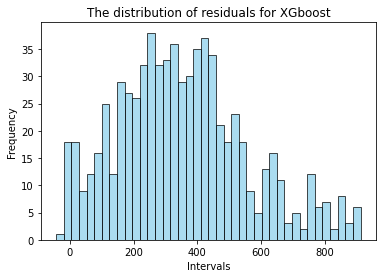

In [ ]:
# plot residuals distribution of XGBoost
y_test_predict = xgbModel.predict(X_test_xgb)
residuals = y_test_xgb.Close - y_test_predict
plt.hist(residuals, bins=40, facecolor="skyblue", edgecolor="black", alpha=0.7)
plt.xlabel("Intervals")
plt.ylabel("Frequency")
plt.title("The distribution of residuals for XGboost")
plt.show()

# ARIMA

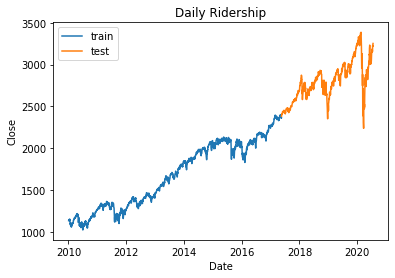

In [ ]:
X_ARIMA = sp500df[['Close']].copy()
cutpoint = int(len(X_ARIMA) * 0.7)
train_ARIMA, test_ARIMA = X_ARIMA[0:cutpoint], X_ARIMA[cutpoint:]
X_ARIMA['d1'] = X_ARIMA.diff(1)
X_ARIMA['d2'] = X_ARIMA['d1'].diff(1)

#Plotting original stock price
plt.title('Daily Ridership')
plt.plot(sp500df[['Date']][0:cutpoint], train_ARIMA, label='train')
plt.plot(sp500df[['Date']][cutpoint:], test_ARIMA, label='test')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close')
plt.show()


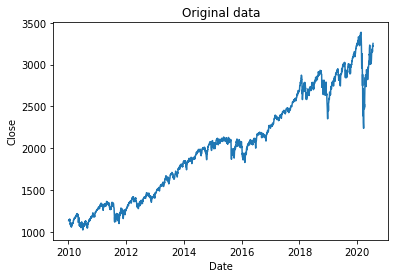

standard deviance: 621.9091


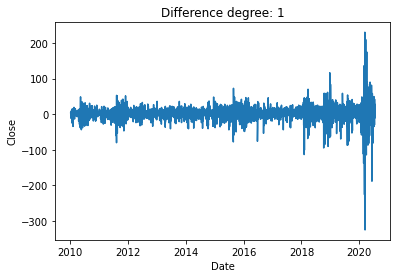

standard deviance: 24.1394


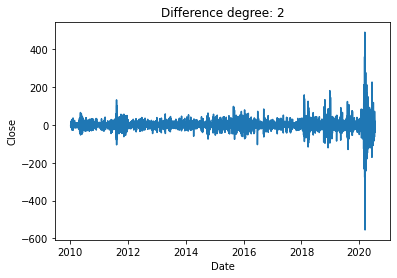

standard deviance: 37.26589310604116


In [ ]:
# plot for differencing
plt.plot(sp500df[['Date']], X_ARIMA['Close'])
plt.title("Original data")
plt.xlabel("Date")
plt.ylabel("Close")
plt.show()
print(f"standard deviance: {stdev(X_ARIMA['Close']):.4f}")

# differencing degree: 1
plt.plot(sp500df[['Date']], X_ARIMA['d1'])
plt.title("Difference degree: 1")
plt.xlabel("Date")
plt.ylabel("Close")
plt.show()
print(f"standard deviance: {stdev(X_ARIMA['d1'].dropna()):.4f}")

# differencing degree: 2
plt.plot(sp500df[['Date']], X_ARIMA['d2'])
plt.title("Difference degree: 2")
plt.xlabel("Date")
plt.ylabel("Close")
plt.show()
print(f"standard deviance: {stdev(X_ARIMA['d2'].dropna())}")
# diff1 get the best result since the sd is the lowest, stable data


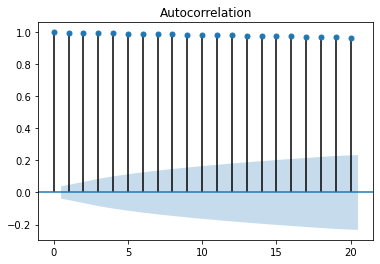

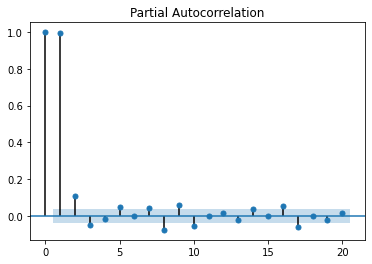

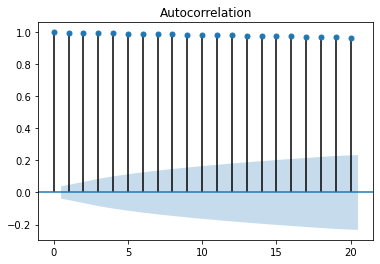

In [ ]:
# plot PACF and ACF
plot_pacf(X_ARIMA['Close'],lags=20)
# so take range of p for AR from 1 - 5 to test
plot_acf(X_ARIMA['Close'],lags=20)
# not in the.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC (4, 0)
BIC (2, 0)


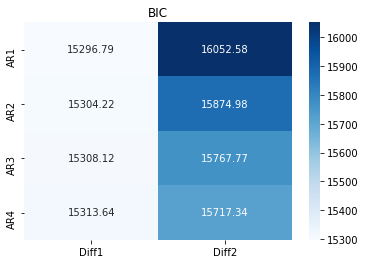

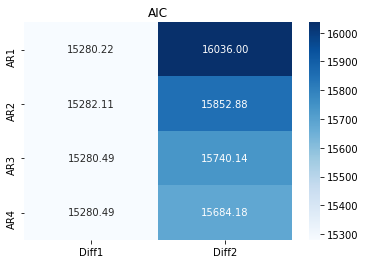

In [ ]:
# try different combinations after estimating parameters, and select best based on AIC and BIC
train_results = arma_order_select_ic(train_ARIMA, ic=['aic', 'bic'], trend='nc', max_ar=4, max_ma=0)
print('AIC', train_results.aic_min_order)
print('BIC', train_results.bic_min_order)

p, d, q = list(range(1,5,1)), [1,2], 0
list_bic = pd.DataFrame(index=[f'AR{i}' for i in p],columns=[f'Diff{j}' for j in d])
list_aic = pd.DataFrame(index=[f'AR{i}' for i in p],columns=[f'Diff{j}' for j in d])

for i in p:
    for j in d:
        model = ARIMA(train_ARIMA, order=(i,j,q))
        model_fit = model.fit(disp=0)
        list_bic.loc[f'AR{i}',f'Diff{j}'] = model_fit.bic
        list_aic.loc[f'AR{i}',f'Diff{j}'] = model_fit.aic

list_bic = list_bic.astype(float)
list_aic = list_aic.astype(float)

sns.heatmap(list_bic, mask=list_bic.isnull(), annot=True, fmt='.2f', cmap = "Blues")
plt.title('BIC')
plt.show()

sns.heatmap(list_aic, mask=list_aic.isnull(), annot=True, fmt='.2f', cmap = "Blues")
plt.title('AIC')
plt.show()

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1856
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -7637.108
Method:                       css-mle   S.D. of innovations             14.819
Date:                Fri, 16 Oct 2020   AIC                          15280.215
Time:                        16:22:02   BIC                          15296.794
Sample:                             1   HQIC                         15286.326
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.6640      0.333      1.996      0.046       0.012       1.316
ar.L1.D.Close    -0.0342      0.023     -1.476      0.140      -0.080       0.011
                                    Root

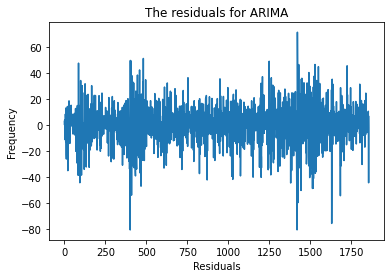

In [ ]:
# Build the model according to the optimal combination is 1,1,0. 
model = ARIMA(train_ARIMA, order=(1,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# plot residual errors
plt.plot(model_fit.resid)
plt.title("The residuals for ARIMA")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

RMSE: 37.0742
Accuracy: 98.6757%


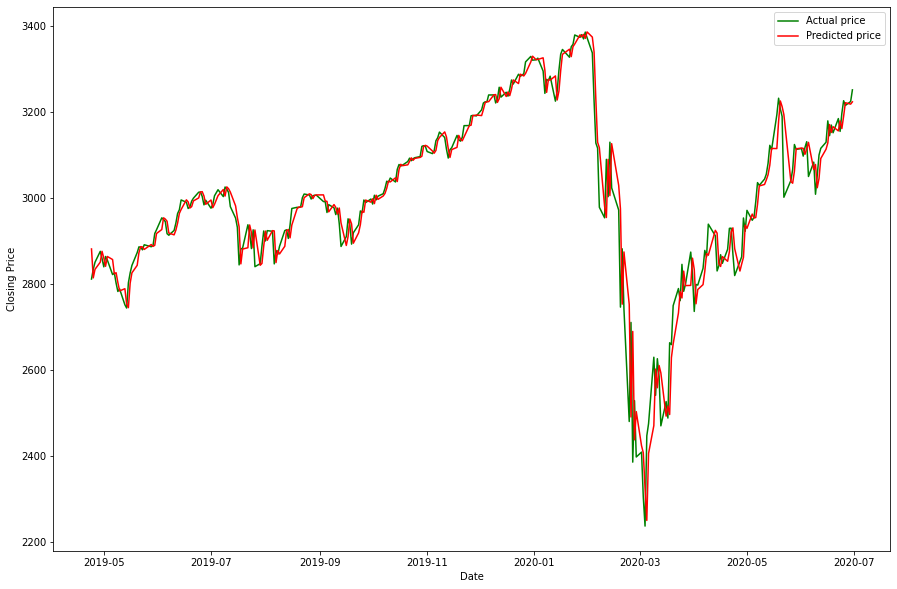

In [ ]:
# For prediction
train_ARIMA_list = train_ARIMA.values.tolist()
yhat_sum = []
for t in range(len(test_ARIMA)):
  model = ARIMA(train_ARIMA_list, order=(1,1,0))
  ## train the trainset then predict one vlaue of the following day
  model_fit = model.fit(disp=0)
  next_yhat = model_fit.forecast()[0]
  ## return only one value which is the following next value
  yhat_sum.append(next_yhat)
  # append this value to a list
  y_real = test_ARIMA.values.tolist()[t]
  # true value of y in testset
  train_ARIMA_list.append(y_real)
  # apeend this true value to the trainset in order to get the second following day value


MSE = mean_squared_error(test_ARIMA, yhat_sum)
RMSE = np.sqrt(MSE)
Accuracy = (1-RMSE/np.mean(test_ARIMA))*100
print(f'RMSE: {RMSE:.4f}')
print(f'Accuracy: {float(Accuracy):.4f}%')
# RMSE: 37.0742
# Accuracy: 98.6757%

#Plotting original stock price
plt.figure(figsize=(15,10))
#plt.title('Actual and Predicted price for ARIMA')
plt.plot(sp500df_cp[['Date']].iloc[-300:,], test_ARIMA[-300:], label='Actual price',color='green')
plt.plot(sp500df_cp[['Date']].iloc[-300:,], yhat_sum[-300:], label='Predicted price',color='red')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

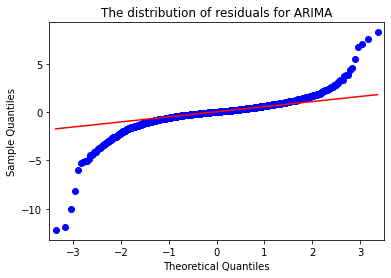

In [ ]:
# plot resid
resid = model_fit.resid
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.set_title("The distribution of residuals for ARIMA")
fig = qqplot(resid, line='q', ax=ax, fit=True)

# RNN LSTM

In [ ]:
# Normalization
Y = sp500df_cp[['Close']]
X = sp500df_cp.drop(columns=['Date'])
# no arima
# Y = sp500df2[['Close']]
# X = sp500df2.drop(columns=['Date'])
scalerX = preprocessing.MinMaxScaler().fit(X)
scaled_X = scalerX.transform(X)
scalerY = preprocessing.MinMaxScaler().fit(Y)
scaled_Y = scalerY.transform(Y)

# Define timestep
def timestep_processing(X,Y,timestep):
    X_timestep, Y_timestep = [], []
    for i in range(len(X)-timestep):
        X_timestep.append(X[i:i+timestep])
        Y_timestep.append(Y[i+timestep, 0])
    return X_timestep, Y_timestep

X_5, Y_5 = timestep_processing(scaled_X,scaled_Y,60)
np.random.seed(2020)
np.random.shuffle(X_5)
np.random.seed(2020)
np.random.shuffle(Y_5)

# Train-test split
cutNo = int(round((1-0.3)*len(X_5)))
X_train, X_test = np.array(X_5[:cutNo]), np.array(X_5[cutNo:])
y_train, y_test = np.array(Y_5[:cutNo]), np.array(Y_5[cutNo:])

In [ ]:
# Function of RNN/LSTM
from keras.layers.wrappers import TimeDistributed
from keras.layers.core import Activation
def NN(X_train, y_train, X_test, y_test, NNtype):
    model = Sequential()
    if NNtype == 'RNN':
      model.add(SimpleRNN(64, return_sequences=True))
    elif NNtype == 'LSTM':
      model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.3))
    # if NNtype == 'RNN':
    #   model.add(SimpleRNN(64, return_sequences=True))
    # elif NNtype == 'LSTM':
    #   model.add(LSTM(64, return_sequences=True))
    # model.add(Dropout(0.3))
    if NNtype == 'RNN':
      model.add(SimpleRNN(64, return_sequences=False))
    elif NNtype == 'LSTM':
      model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    # model.add(Activation("linear"))
    model.compile(loss='mean_squared_error', optimizer='Adamax')
    history = model.fit(X_train, y_train, epochs=30, batch_size=10, verbose=1,validation_data=(X_test, y_test),validation_freq=1)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    predicted_Y = model.predict(X_test)
    return loss, val_loss,model, predicted_Y

Epoch 1/30
167/167 [==============================] - 3s 15ms/step - loss: 0.3669 - val_loss: 0.0257
Epoch 2/30
167/167 [==============================] - 2s 13ms/step - loss: 0.1941 - val_loss: 0.0064
Epoch 3/30
167/167 [==============================] - 2s 13ms/step - loss: 0.1344 - val_loss: 0.0106
Epoch 4/30
167/167 [==============================] - 2s 13ms/step - loss: 0.0944 - val_loss: 0.0110
Epoch 5/30
167/167 [==============================] - 2s 14ms/step - loss: 0.0789 - val_loss: 0.0053
Epoch 6/30
167/167 [==============================] - 2s 14ms/step - loss: 0.0617 - val_loss: 0.0035
Epoch 7/30
167/167 [==============================] - 2s 13ms/step - loss: 0.0531 - val_loss: 0.0013
Epoch 8/30
167/167 [==============================] - 2s 13ms/step - loss: 0.0403 - val_loss: 0.0016
Epoch 9/30
167/167 [==============================] - 2s 13ms/step - loss: 0.0381 - val_loss: 0.0014
Epoch 10/30
167/167 [==============================] - 2s 13ms/step - loss: 0.0289 - val_lo

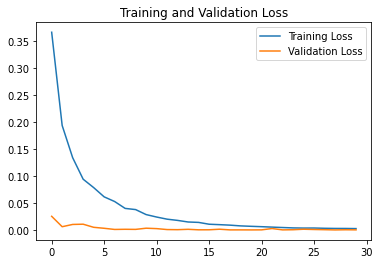

In [ ]:
# train
loss,val_loss,model,predicted_Y = NN(X_train, y_train, X_test, y_test,'RNN')
predicted_Y = model.predict(X_train)
predicted_Y = scalerY.inverse_transform(predicted_Y)
y_train = y_train.reshape(len(y_train),1)
y_train_real = scalerY.inverse_transform(y_train)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
# plt.figure(figsize=(15, 5))
# plt.plot(y_train_real, color='red', label='Real SPX Price')
# plt.plot(predicted_Y, color='blue', label='Predicted SPX Price')
# plt.title('SPX Price Prediction')
# plt.xlabel('Timestep')
# plt.ylabel('SPX Price')
# plt.legend()
# plt.show()


MSE: 2971.041890
RMSE: 54.507265
Accuracy: 97.42%


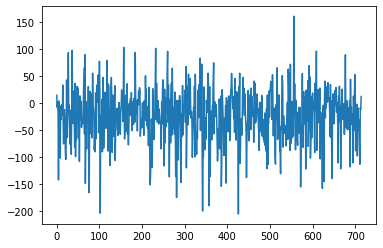

In [ ]:
# test
predicted_Y = model.predict(X_test)
predicted_Y = scalerY.inverse_transform(predicted_Y)
y_test = y_test.reshape(len(y_test),1)
y_test_real = scalerY.inverse_transform(y_test)
# plt.figure(figsize=(15, 5))
# plt.plot(y_test_real, color='red', label='Real SPX Price')
# plt.plot(predicted_Y, color='blue', label='Predicted SPX Price')
# plt.title('SPX Price Prediction')
# plt.xlabel('Timestep')
# plt.ylabel('SPX Price')
# plt.legend()
# plt.show()

# Calculate error and accuracy
MSE = mean_squared_error(predicted_Y, y_test_real)
RMSE = math.sqrt(MSE)
y_test_real_mean = np.mean(y_test_real)
Accuracy = (1-RMSE/y_test_real_mean)
print('MSE: %.6f' % MSE)
print('RMSE: %.6f' % RMSE)
print('Accuracy: %.2f%%' % (Accuracy*100))

# np.sum(np.abs((y_test_real - predicted_Y) / y_test_real) > 0.03) / len(y_test_real)
plt.plot(y_test_real - predicted_Y)
plt.show()

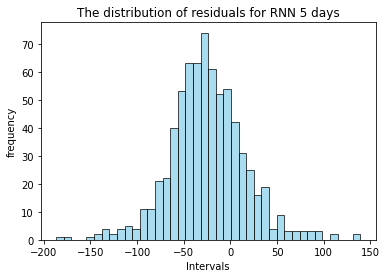

In [ ]:
# Plot residuals
residuals = y_test_real - predicted_Y
plt.hist(residuals, bins=40, facecolor="skyblue", edgecolor="black", alpha=0.7)
plt.xlabel("Intervals")
plt.ylabel("frequency")
plt.title("The distribution of residuals for RNN 5 days")
plt.show()